In [44]:

%matplotlib inline
import matplotlib
import matplotlib.dates as mdates
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect
from sqlalchemy import Column, Integer, String, Float, Boolean
from sqlalchemy.orm import declarative_base
Base = declarative_base()

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)

In [13]:
inspector.get_table_names()

['measurement', 'station']

In [14]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [17]:
# Calculate the date one year from the last date in data set.

dt.date(2017, 8, 23)-dt.timedelta(days=365)

datetime.date(2016, 8, 23)

In [73]:

# Perform a query to retrieve the date and precipitation scores
percip_values = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).\
    filter(Measurement.date >= ('2016-08-23')).\
    filter(Measurement.date <= ('2017-08-23')).all()

In [74]:


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(percip_values, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)
print(df.head())



            precipitation
date                     
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45
2017-08-22           0.00


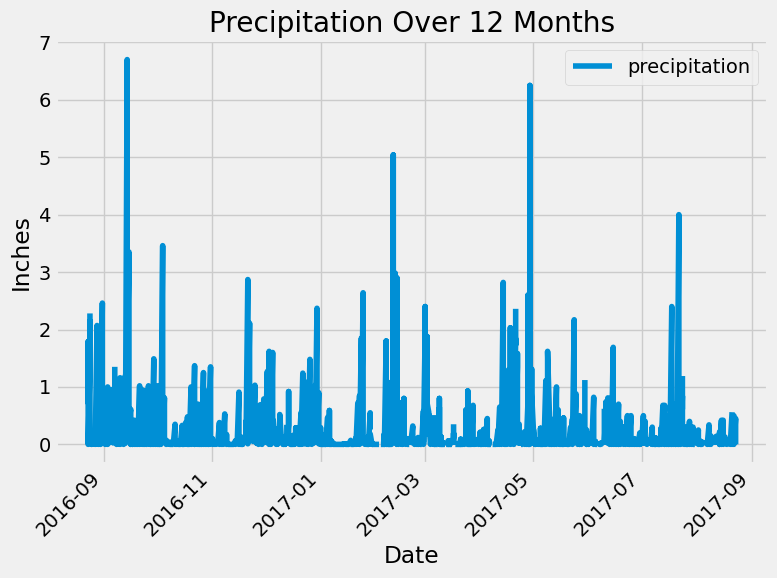

In [76]:

# Use Pandas Plotting with Matplotlib to plot the data

df.plot(figsize=(8, 6))
plt.title('Precipitation Over 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary_stats = df['precipitation'].describe()
print(precip_summary_stats)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [62]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).distinct().count()
print(total_stations)

9


In [64]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [65]:
# Find the most active station
most_active_station = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
most_active_station

'USC00519281'

In [66]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_mas = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()
temp_mas

[(54.0, 85.0, 71.66378066378067)]

In [70]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
tobs_values = session.query(Measurement.date, Measurement.tobs).order_by(Measurement.date.desc()).\
    filter(Measurement.date >= ('2016-08-23')).\
    filter(Measurement.station == most_active_station).all()


In [71]:
#Create Dataframe
tobs_df = pd.DataFrame(tobs_values, columns=['date', 'tobs'])
tobs_df.set_index('date', inplace=True)

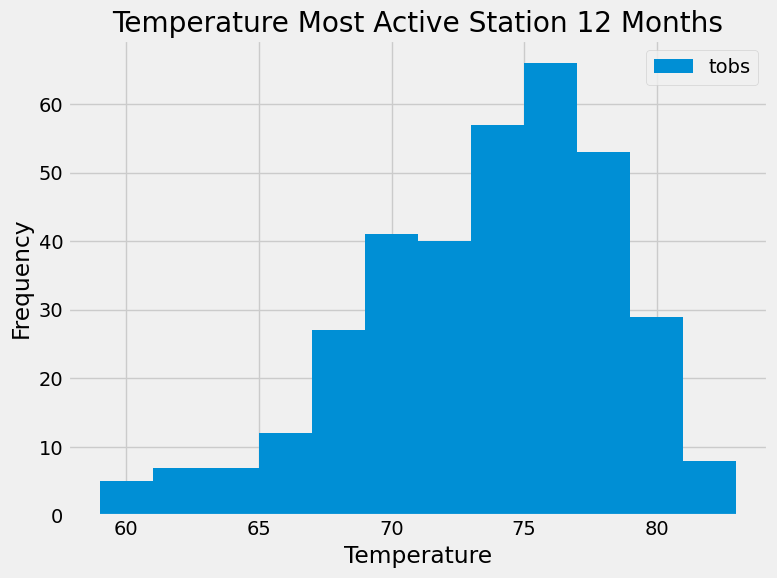

In [72]:
# plot the results as a histogram
tobs_df['tobs'].plot(kind='hist', bins=12, figsize=(8, 6))
plt.title('Temperature Most Active Station 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [77]:
# Close Session
session.close()